## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp030'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 256 #224
    tile_size = 256 #224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 3 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.PiecewiseAffine(p=0.3), #IAAPiecewiseAffine
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 256, 256])

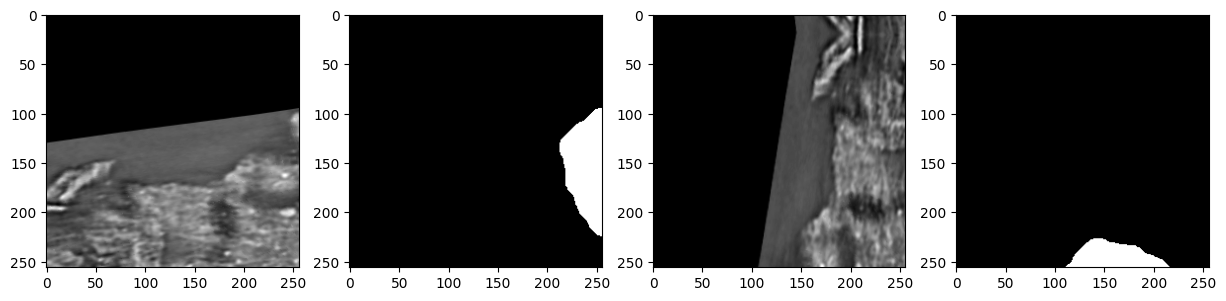

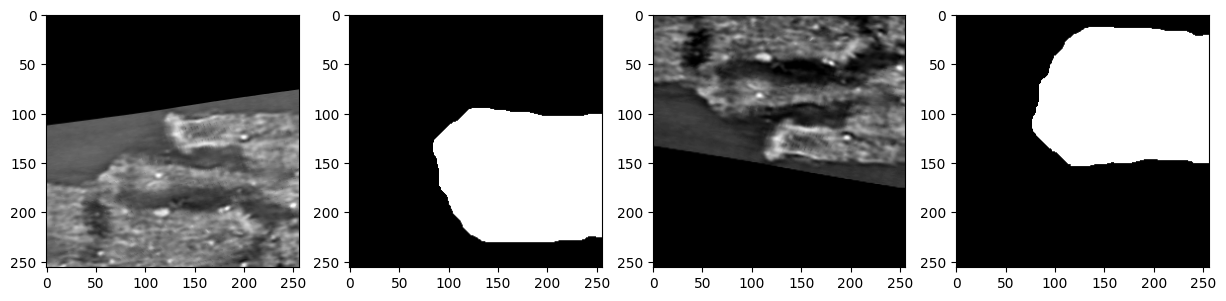

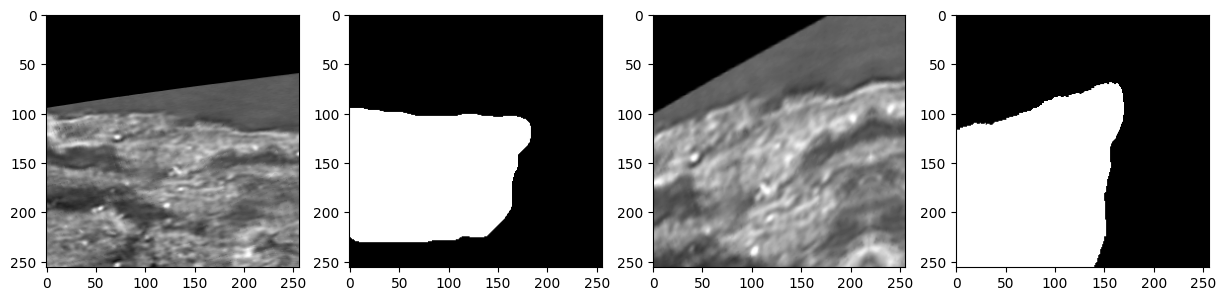

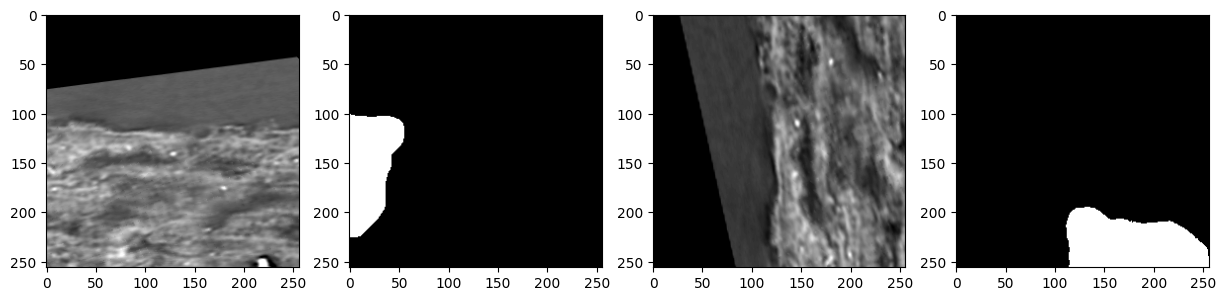

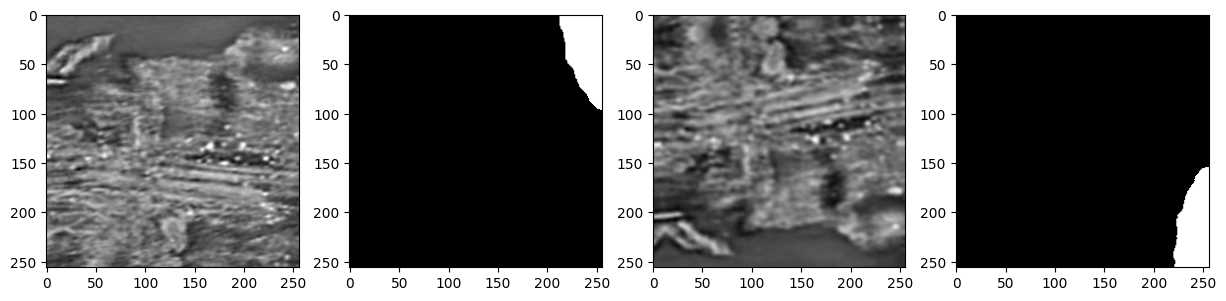

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

50664

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/732 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.09423837390719053
th: 0.15, fbeta: 0.09426634820106246
th: 0.2, fbeta: 0.09599945995298656
th: 0.25, fbeta: 0.1532735897652949
th: 0.3, fbeta: 0.19562533139059018
th: 0.35, fbeta: 0.25137076932478014
th: 0.4, fbeta: 0.3128308168645399


best_th: 0.5, fbeta: 0.4077682759380364
Epoch 1 - avg_train_loss: 0.6014  avg_val_loss: 0.4170  time: 139s
Epoch 1 - avgScore: 0.4078
Epoch 1 - Save Best Score: 0.4078 Model
Epoch 1 - Save Best Loss: 0.4170 Model


th: 0.45, fbeta: 0.36657986579452617
th: 0.5, fbeta: 0.4077682759380364


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.0942379831802364
th: 0.15, fbeta: 0.09526807655976903
th: 0.2, fbeta: 0.1602772648925992
th: 0.25, fbeta: 0.2595800544366027
th: 0.3, fbeta: 0.3674863551201501
th: 0.35, fbeta: 0.427894199750387
th: 0.4, fbeta: 0.4645167632012002


best_th: 0.5, fbeta: 0.48932348445905466
Epoch 2 - avg_train_loss: 0.4129  avg_val_loss: 0.3198  time: 142s
Epoch 2 - avgScore: 0.4893
Epoch 2 - Save Best Score: 0.4893 Model
Epoch 2 - Save Best Loss: 0.3198 Model


th: 0.45, fbeta: 0.4852629904428443
th: 0.5, fbeta: 0.48932348445905466


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:728: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


th: 0.1, fbeta: 0.37338104310751197
th: 0.15, fbeta: 0.46177692822983435
th: 0.2, fbeta: 0.4983786675048129
th: 0.25, fbeta: 0.51367867012988
th: 0.3, fbeta: 0.5231598941548936
th: 0.35, fbeta: 0.5228078566282558
th: 0.4, fbeta: 0.5106101883184077
th: 0.45, fbeta: 0.4896460222441095


best_th: 0.3, fbeta: 0.5231598941548936
Epoch 3 - avg_train_loss: 0.3054  avg_val_loss: 0.2019  time: 142s
Epoch 3 - avgScore: 0.5232
Epoch 3 - Save Best Score: 0.5232 Model
Epoch 3 - Save Best Loss: 0.2019 Model


th: 0.5, fbeta: 0.4564934780918094


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2811939809804596
th: 0.15, fbeta: 0.3447824878748268
th: 0.2, fbeta: 0.3939490610995598
th: 0.25, fbeta: 0.43418635902321706
th: 0.3, fbeta: 0.47034005819663494
th: 0.35, fbeta: 0.5060815220241196
th: 0.4, fbeta: 0.5350572044334998
th: 0.45, fbeta: 0.5543927068783706


best_th: 0.5, fbeta: 0.5683641189538564
Epoch 4 - avg_train_loss: 0.2570  avg_val_loss: 0.1879  time: 142s
Epoch 4 - avgScore: 0.5684
Epoch 4 - Save Best Score: 0.5684 Model
Epoch 4 - Save Best Loss: 0.1879 Model


th: 0.5, fbeta: 0.5683641189538564


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32150604413323497
th: 0.15, fbeta: 0.3765204968911491
th: 0.2, fbeta: 0.4247891078956236
th: 0.25, fbeta: 0.4778915104849375
th: 0.3, fbeta: 0.5155777617562411
th: 0.35, fbeta: 0.5346875121483898
th: 0.4, fbeta: 0.5424733577635708
th: 0.45, fbeta: 0.5421117001724344


best_th: 0.4, fbeta: 0.5424733577635708
Epoch 5 - avg_train_loss: 0.2386  avg_val_loss: 0.1898  time: 142s
Epoch 5 - avgScore: 0.5425


th: 0.5, fbeta: 0.5339503116468337


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.21198916464320547
th: 0.15, fbeta: 0.24091516302468777
th: 0.2, fbeta: 0.27258852516380216
th: 0.25, fbeta: 0.303764887233277
th: 0.3, fbeta: 0.33313637739577306
th: 0.35, fbeta: 0.3625225766394737
th: 0.4, fbeta: 0.392226674478302
th: 0.45, fbeta: 0.42159078753848084


best_th: 0.5, fbeta: 0.4489223190988256
Epoch 6 - avg_train_loss: 0.2251  avg_val_loss: 0.2366  time: 142s
Epoch 6 - avgScore: 0.4489


th: 0.5, fbeta: 0.4489223190988256


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2574586909987712
th: 0.15, fbeta: 0.30748579730861897
th: 0.2, fbeta: 0.3548938455245186
th: 0.25, fbeta: 0.3976590053066987
th: 0.3, fbeta: 0.43563156311910733
th: 0.35, fbeta: 0.4713319518577172
th: 0.4, fbeta: 0.5040871905901689
th: 0.45, fbeta: 0.5274509701208118


best_th: 0.5, fbeta: 0.5472175223112559
Epoch 7 - avg_train_loss: 0.2122  avg_val_loss: 0.1957  time: 142s
Epoch 7 - avgScore: 0.5472


th: 0.5, fbeta: 0.5472175223112559


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2889037669124895
th: 0.15, fbeta: 0.3212831439936253
th: 0.2, fbeta: 0.351619565723545
th: 0.25, fbeta: 0.3825218186985781
th: 0.3, fbeta: 0.4122777214825564
th: 0.35, fbeta: 0.43837013368140304
th: 0.4, fbeta: 0.46203213528955306
th: 0.45, fbeta: 0.48157681794604845


best_th: 0.5, fbeta: 0.49827378978521014
Epoch 8 - avg_train_loss: 0.1987  avg_val_loss: 0.2297  time: 142s
Epoch 8 - avgScore: 0.4983


th: 0.5, fbeta: 0.49827378978521014


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3721081642780339
th: 0.15, fbeta: 0.4206264597049245
th: 0.2, fbeta: 0.4623660476893727
th: 0.25, fbeta: 0.4960206736828449
th: 0.3, fbeta: 0.5236143195644882
th: 0.35, fbeta: 0.5457715688742366
th: 0.4, fbeta: 0.5618927470814816
th: 0.45, fbeta: 0.5716510210681812


best_th: 0.5, fbeta: 0.5786878594181508
Epoch 9 - avg_train_loss: 0.1861  avg_val_loss: 0.1887  time: 143s
Epoch 9 - avgScore: 0.5787
Epoch 9 - Save Best Score: 0.5787 Model
Epoch 9 - Save Best Loss: 0.1887 Model


th: 0.5, fbeta: 0.5786878594181508


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3222684786512695
th: 0.15, fbeta: 0.3647930483022522
th: 0.2, fbeta: 0.4014708012135691
th: 0.25, fbeta: 0.43349100635450305
th: 0.3, fbeta: 0.4647801871872883
th: 0.35, fbeta: 0.4917572216501129
th: 0.4, fbeta: 0.5168199181760863
th: 0.45, fbeta: 0.541223930101065


best_th: 0.5, fbeta: 0.5574270046838457
Epoch 10 - avg_train_loss: 0.1752  avg_val_loss: 0.1945  time: 142s
Epoch 10 - avgScore: 0.5574


th: 0.5, fbeta: 0.5574270046838457


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2541152826946074
th: 0.15, fbeta: 0.28307730447764756
th: 0.2, fbeta: 0.3074556538250805
th: 0.25, fbeta: 0.3306982631764153
th: 0.3, fbeta: 0.3528832511358863
th: 0.35, fbeta: 0.3748908422105225
th: 0.4, fbeta: 0.3969095311305261
th: 0.45, fbeta: 0.4169284472600202


best_th: 0.5, fbeta: 0.4357231482718925
Epoch 11 - avg_train_loss: 0.1644  avg_val_loss: 0.2523  time: 142s
Epoch 11 - avgScore: 0.4357


th: 0.5, fbeta: 0.4357231482718925


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33099292943943626
th: 0.15, fbeta: 0.36800129828390565
th: 0.2, fbeta: 0.3987270248177618
th: 0.25, fbeta: 0.4268170439461399
th: 0.3, fbeta: 0.4533830117259564
th: 0.35, fbeta: 0.4781032562424821
th: 0.4, fbeta: 0.4995339567683063


best_th: 0.5, fbeta: 0.5310889187700737
Epoch 12 - avg_train_loss: 0.1536  avg_val_loss: 0.2041  time: 142s
Epoch 12 - avgScore: 0.5311


th: 0.45, fbeta: 0.5174454996304564
th: 0.5, fbeta: 0.5310889187700737


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29054676729201684
th: 0.15, fbeta: 0.3199465433003013
th: 0.2, fbeta: 0.34770467598182314
th: 0.25, fbeta: 0.37408355078510774
th: 0.3, fbeta: 0.39903188574696924
th: 0.35, fbeta: 0.42430409118085305
th: 0.4, fbeta: 0.44817793565148406
th: 0.45, fbeta: 0.47007804419864124


best_th: 0.5, fbeta: 0.4897571760954294
Epoch 13 - avg_train_loss: 0.1424  avg_val_loss: 0.2339  time: 143s
Epoch 13 - avgScore: 0.4898


th: 0.5, fbeta: 0.4897571760954294


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33643605391834785
th: 0.15, fbeta: 0.37013884170471695
th: 0.2, fbeta: 0.3986765704571689
th: 0.25, fbeta: 0.4258638949607094
th: 0.3, fbeta: 0.45355089415498123
th: 0.35, fbeta: 0.47652865645000503
th: 0.4, fbeta: 0.4963349840598871
th: 0.45, fbeta: 0.5153046297677711


best_th: 0.5, fbeta: 0.5330809011006276
Epoch 14 - avg_train_loss: 0.1375  avg_val_loss: 0.2243  time: 143s
Epoch 14 - avgScore: 0.5331


th: 0.5, fbeta: 0.5330809011006276


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3254181098880013
th: 0.15, fbeta: 0.3625568684622434
th: 0.2, fbeta: 0.3946131033173136
th: 0.25, fbeta: 0.42298884358311173
th: 0.3, fbeta: 0.44600814970160696
th: 0.35, fbeta: 0.467527737894628
th: 0.4, fbeta: 0.48546603503349756
th: 0.45, fbeta: 0.5001617545467306


best_th: 0.5, fbeta: 0.5146299223666488
Epoch 15 - avg_train_loss: 0.1281  avg_val_loss: 0.2186  time: 143s
Epoch 15 - avgScore: 0.5146


th: 0.5, fbeta: 0.5146299223666488


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3155342394865618
th: 0.15, fbeta: 0.3464527771593335
th: 0.2, fbeta: 0.37371550143443877
th: 0.25, fbeta: 0.39654566121545426
th: 0.3, fbeta: 0.4167553167768668
th: 0.35, fbeta: 0.43663981188767276
th: 0.4, fbeta: 0.45506490246729797


best_th: 0.5, fbeta: 0.49061410197239974
Epoch 16 - avg_train_loss: 0.1206  avg_val_loss: 0.2527  time: 143s
Epoch 16 - avgScore: 0.4906


th: 0.45, fbeta: 0.4745010862789934
th: 0.5, fbeta: 0.49061410197239974


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37591730653849287
th: 0.15, fbeta: 0.41599527654256674
th: 0.2, fbeta: 0.445735011914644
th: 0.25, fbeta: 0.4707657642969598
th: 0.3, fbeta: 0.4912193539021012
th: 0.35, fbeta: 0.5068701956443554
th: 0.4, fbeta: 0.5199317840090536
th: 0.45, fbeta: 0.5333014405339613


best_th: 0.5, fbeta: 0.5418513530929749
Epoch 17 - avg_train_loss: 0.1157  avg_val_loss: 0.2324  time: 142s
Epoch 17 - avgScore: 0.5419


th: 0.5, fbeta: 0.5418513530929749


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31541810993142794
th: 0.15, fbeta: 0.3454782055742539
th: 0.2, fbeta: 0.3727532750751033
th: 0.25, fbeta: 0.397284429216807
th: 0.3, fbeta: 0.4175812558090298
th: 0.35, fbeta: 0.43885602618050806
th: 0.4, fbeta: 0.4595369044576894
th: 0.45, fbeta: 0.48120895142445597


best_th: 0.5, fbeta: 0.5021900472171442
Epoch 18 - avg_train_loss: 0.1067  avg_val_loss: 0.2390  time: 143s
Epoch 18 - avgScore: 0.5022


th: 0.5, fbeta: 0.5021900472171442


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2801268216793983
th: 0.15, fbeta: 0.3038952507732243
th: 0.2, fbeta: 0.32632377542462626
th: 0.25, fbeta: 0.3477455405952031
th: 0.3, fbeta: 0.36899766165512915
th: 0.35, fbeta: 0.3905562175066062
th: 0.4, fbeta: 0.4116208327066056
th: 0.45, fbeta: 0.43346980108651584


best_th: 0.5, fbeta: 0.4550922884073134
Epoch 19 - avg_train_loss: 0.1030  avg_val_loss: 0.2530  time: 143s
Epoch 19 - avgScore: 0.4551


th: 0.5, fbeta: 0.4550922884073134


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32234019346155657
th: 0.15, fbeta: 0.35244686193551383
th: 0.2, fbeta: 0.3814335650364668
th: 0.25, fbeta: 0.40854927688153925
th: 0.3, fbeta: 0.43312426084924066
th: 0.35, fbeta: 0.4562962298232405
th: 0.4, fbeta: 0.47616994334260426
th: 0.45, fbeta: 0.49574586265591364


best_th: 0.5, fbeta: 0.5111247936027901
Epoch 20 - avg_train_loss: 0.0974  avg_val_loss: 0.2583  time: 143s
Epoch 20 - avgScore: 0.5111


th: 0.5, fbeta: 0.5111247936027901


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2972132741456116
th: 0.15, fbeta: 0.32039269239124485
th: 0.2, fbeta: 0.34152385253029155
th: 0.25, fbeta: 0.3611085407958615
th: 0.3, fbeta: 0.37955882201307795
th: 0.35, fbeta: 0.3997806852287362
th: 0.4, fbeta: 0.42128546622326274
th: 0.45, fbeta: 0.44087464351403893


best_th: 0.5, fbeta: 0.4564763785165096
Epoch 21 - avg_train_loss: 0.0929  avg_val_loss: 0.2636  time: 144s
Epoch 21 - avgScore: 0.4565


th: 0.5, fbeta: 0.4564763785165096


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2869397718694399
th: 0.15, fbeta: 0.31647725815284106
th: 0.2, fbeta: 0.34067591200863595
th: 0.25, fbeta: 0.3632585232128231
th: 0.3, fbeta: 0.38564120481233394
th: 0.35, fbeta: 0.4078990393751047
th: 0.4, fbeta: 0.42883485064287097
th: 0.45, fbeta: 0.44750579587809375


best_th: 0.5, fbeta: 0.4678442406161647
Epoch 22 - avg_train_loss: 0.0878  avg_val_loss: 0.2671  time: 143s
Epoch 22 - avgScore: 0.4678


th: 0.5, fbeta: 0.4678442406161647


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33851347601329
th: 0.15, fbeta: 0.3664351769161548
th: 0.2, fbeta: 0.39088296922024557
th: 0.25, fbeta: 0.41106415856429585
th: 0.3, fbeta: 0.4321427457487862
th: 0.35, fbeta: 0.4512846549901509
th: 0.4, fbeta: 0.4676125132555559
th: 0.45, fbeta: 0.4830462385616951


best_th: 0.5, fbeta: 0.4959437433420912
Epoch 23 - avg_train_loss: 0.0832  avg_val_loss: 0.2742  time: 143s
Epoch 23 - avgScore: 0.4959


th: 0.5, fbeta: 0.4959437433420912


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33064762681477516
th: 0.15, fbeta: 0.36139606279448966
th: 0.2, fbeta: 0.38761195665678266
th: 0.25, fbeta: 0.4096026131737973
th: 0.3, fbeta: 0.4311396572679224
th: 0.35, fbeta: 0.4518983923382157
th: 0.4, fbeta: 0.4718915373971437
th: 0.45, fbeta: 0.4897168174111407


best_th: 0.5, fbeta: 0.5039329960721108
Epoch 24 - avg_train_loss: 0.0795  avg_val_loss: 0.2630  time: 143s
Epoch 24 - avgScore: 0.5039


th: 0.5, fbeta: 0.5039329960721108


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34179239023084046
th: 0.15, fbeta: 0.37059381526789503
th: 0.2, fbeta: 0.39509088389408137
th: 0.25, fbeta: 0.4174117779107284
th: 0.3, fbeta: 0.4383702653341313
th: 0.35, fbeta: 0.45752783102746053
th: 0.4, fbeta: 0.4767647068727936


best_th: 0.5, fbeta: 0.5078836707168327
Epoch 25 - avg_train_loss: 0.0771  avg_val_loss: 0.2719  time: 143s
Epoch 25 - avgScore: 0.5079


th: 0.45, fbeta: 0.493772259342342
th: 0.5, fbeta: 0.5078836707168327


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3370697614194499
th: 0.15, fbeta: 0.36519942470558203
th: 0.2, fbeta: 0.3897102701860008
th: 0.25, fbeta: 0.41308186416950543
th: 0.3, fbeta: 0.43519014434069353
th: 0.35, fbeta: 0.4518699528389473
th: 0.4, fbeta: 0.4674207942979155
th: 0.45, fbeta: 0.4830633169112079


best_th: 0.5, fbeta: 0.4989300122395186
Epoch 26 - avg_train_loss: 0.0751  avg_val_loss: 0.2848  time: 143s
Epoch 26 - avgScore: 0.4989


th: 0.5, fbeta: 0.4989300122395186


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31124554148658445
th: 0.15, fbeta: 0.3385365546567869
th: 0.2, fbeta: 0.36242261340562637
th: 0.25, fbeta: 0.3810770986021995
th: 0.3, fbeta: 0.4006294587071103
th: 0.35, fbeta: 0.41981231647973793
th: 0.4, fbeta: 0.4380944638299947
th: 0.45, fbeta: 0.4560346517441686


best_th: 0.5, fbeta: 0.4720007980869328
Epoch 27 - avg_train_loss: 0.0735  avg_val_loss: 0.2895  time: 143s
Epoch 27 - avgScore: 0.4720


th: 0.5, fbeta: 0.4720007980869328


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3477919328236148
th: 0.15, fbeta: 0.3759611324020149
th: 0.2, fbeta: 0.3994825398261139
th: 0.25, fbeta: 0.42121169128615443
th: 0.3, fbeta: 0.4421798166885693
th: 0.35, fbeta: 0.4602724493750591
th: 0.4, fbeta: 0.4770783340425757


best_th: 0.5, fbeta: 0.5062296509347659
Epoch 28 - avg_train_loss: 0.0731  avg_val_loss: 0.2812  time: 144s
Epoch 28 - avgScore: 0.5062


th: 0.45, fbeta: 0.4933023716573224
th: 0.5, fbeta: 0.5062296509347659


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3630342721405345
th: 0.15, fbeta: 0.3933293166209159
th: 0.2, fbeta: 0.4176795728727495
th: 0.25, fbeta: 0.43905627598251284
th: 0.3, fbeta: 0.4596925690483569
th: 0.35, fbeta: 0.4785913520068363
th: 0.4, fbeta: 0.49337110224838576
th: 0.45, fbeta: 0.5067757203900298


best_th: 0.5, fbeta: 0.5177224299309964
Epoch 29 - avg_train_loss: 0.0713  avg_val_loss: 0.2878  time: 144s
Epoch 29 - avgScore: 0.5177


th: 0.5, fbeta: 0.5177224299309964


  0%|          | 0/732 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3405106497729848
th: 0.15, fbeta: 0.370387139628333
th: 0.2, fbeta: 0.393694244866148
th: 0.25, fbeta: 0.4153570332637244
th: 0.3, fbeta: 0.4369609144554753
th: 0.35, fbeta: 0.45629394738551043
th: 0.4, fbeta: 0.47337921149502693


best_th: 0.5, fbeta: 0.4998407369087144
Epoch 30 - avg_train_loss: 0.0700  avg_val_loss: 0.2830  time: 143s
Epoch 30 - avgScore: 0.4998


th: 0.45, fbeta: 0.487483921793963
th: 0.5, fbeta: 0.4998407369087144


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.3721081642780339
th: 0.15, fbeta: 0.4206264597049245
th: 0.2, fbeta: 0.4623660476893727
th: 0.25, fbeta: 0.4960206736828449
th: 0.3, fbeta: 0.5236143195644882
th: 0.35, fbeta: 0.5457715688742366
th: 0.4, fbeta: 0.5618927470814816
th: 0.45, fbeta: 0.5716510210681812


best_th: 0.5, fbeta: 0.5786878594181508


th: 0.5, fbeta: 0.5786878594181508


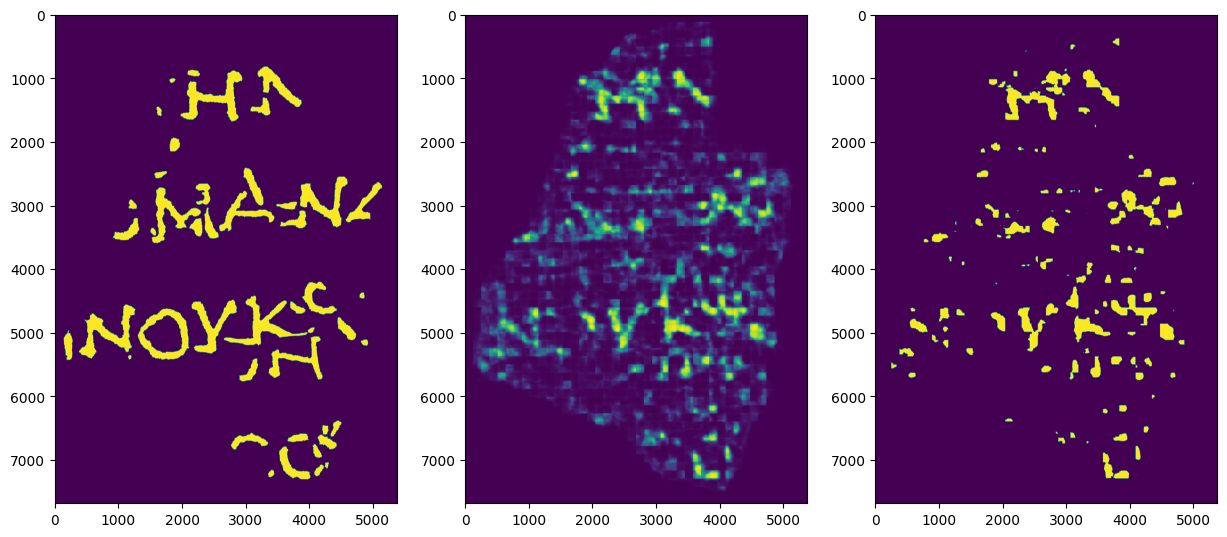

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([30651579.,  3299970.,  1556306.,  1042817.,   749156.,   596751.,
          501598.,   392117.,   313032.,   278877.,   250558.,   247829.,
          217745.,   198821.,   184167.,   180452.,   180962.,   194898.,
          173595.,    76450.]),
 array([2.24690630e-05, 4.94496886e-02, 9.88769082e-02, 1.48304128e-01,
        1.97731347e-01, 2.47158567e-01, 2.96585787e-01, 3.46013006e-01,
        3.95440226e-01, 4.44867445e-01, 4.94294665e-01, 5.43721884e-01,
        5.93149104e-01, 6.42576324e-01, 6.92003543e-01, 7.41430763e-01,
        7.90857982e-01, 8.40285202e-01, 8.89712421e-01, 9.39139641e-01,
        9.88566861e-01]),
 <BarContainer object of 20 artists>)

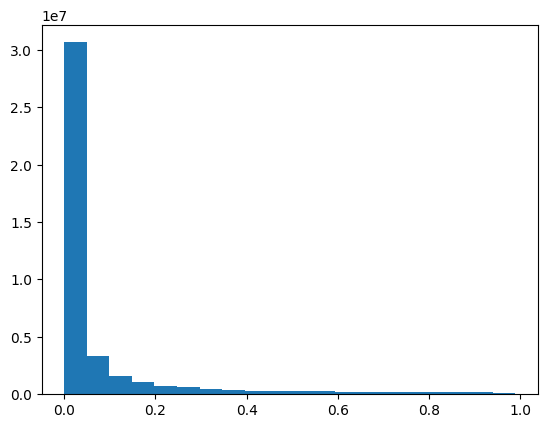

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000